In [1]:
import numpy as np
import scipy.constants as cc

from tabulate import tabulate

import matplotlib.pyplot as plt
from importlib import reload
# from matplotlib import ticker

from RashbaJunction import RashbaJunction2
from RashbaJunction.RashbaJunction_0_4 import WaveVector
from RashbaJunction.utilities import adjuct_Tick, renormallize_result, make_grid
from RashbaJunction.ScatteringMatrix import ScatteringMatrix

ev_to_j = 1.602176634e-19

hbar = 6.582119569e-16
m = 0.015*cc.m_e
h_xy = 0.1e-3*ev_to_j# mJ


# k_z = np.sqrt(2*m*h_xy/ev_to_j)/hbar
k_z = np.sqrt(2*m*h_xy)/cc.hbar# 1/Metr


x = 500e-9# Metr
x_prime =  k_z*x# adimensional
print(f"k_so {k_z}")
print(f"x' {x_prime}")

BASE_PATH = "plots/paper_plots_2/"
# BASE_PATH_DIRAC_PARADOX = "plots/tesi/4_Dirac_paradox/"
# BASE_PATH_SLIDE = "plots/tesi/Slide/"
# BASE_PATH_SLIDE = "/Users/l/Google Drive/polito_/tesi/Text/vesions/Slide/assets/"

print(BASE_PATH)
# print(BASE_PATH_DIRAC_PARADOX)
# print(BASE_PATH_SLIDE)

k_so 6274572.777578376
x' 3.137286388789188
plots/paper_plots_2/


In [2]:
def renormallize_result(res, dy = 10):
#     x_int = x
#     res_int = res
    for v in res.values():
        for i in v:
            pos = np.where(np.abs(np.diff(i)) >= dy)[0]
            if len(pos) != 0:
                i[pos] = np.nan
            pos = 0


def adjuct_Tick(axs, **kwarg):
    from matplotlib import ticker
    if len(axs.shape) == 1:
        ax = axs.reshape(axs.shape[0], 1)
        for k in kwarg.keys():
            if k != "size":
                kwarg[k] = kwarg[k].reshape(axs.shape[0], 1)
    else:
        ax = axs
    
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
                ax[i, j].tick_params(axis='x', labelsize=kwarg["size"])
                ax[i, j].tick_params(axis='y', labelsize=kwarg["size"])
    
                ax[i, j].xaxis.set_major_locator(ticker.MultipleLocator(kwarg["x_magior"][i, j]))
                ax[i, j].xaxis.set_minor_locator(ticker.MultipleLocator(kwarg["x_minor"][i, j]))

                ax[i, j].xaxis.set_ticks_position('both')
    
                ax[i, j].yaxis.set_major_locator(ticker.MultipleLocator(kwarg["y_magior"][i, j]))
                ax[i, j].yaxis.set_minor_locator(ticker.MultipleLocator(kwarg["y_minor"][i, j]))

                ax[i, j].yaxis.set_ticks_position('both')
    
                ax[i, j].tick_params(which='major', width=1.00, length=5)
                ax[i, j].tick_params(which='minor', width=0.75, length=2.5, labelsize=15)
            
def expansion(x):
    # r = eso/h
    return x**2/(1 + (x/2)**2)**2
#     return 1/(1+4*(r)**2) + np.sqrt(1/r)*x + (r)*x**2

def expansion2(x):
    # r = eso/h
    return 16*np.pi**2*x/E_l/(4 + np.pi**2*x/E_l)**2
#     return 1/(1+4*(r)**2) + np.sqrt(1/r)*x + (r)*x**2

# pot set up

In [3]:
font = {'family': "Times New Roman", "size": 25}

# y_label = [r"$$\frac{2 \pi \hbar}{q^2} G$$", r"$$-\frac{6 \hbar}{q \pi k_b^2 T}L$$"]
# y_label = [r"$$ \frac{G}{G_0}$$", r"$$-\frac{6 \hbar}{q \pi k_b^2 T}L$$"]
# x_label = r"$$\frac{E}{E_Z}$$"
y_label = r"$G / G_0$"
x_label = r"$$E / E_{SO}^{(L)}$$"

y_label_pos = [(-.02, 1.03), (-.09, 1)]

legend_font_size = 25

region_lbl = ["(a)", "(b)", "(c)"]

# Pure Rashba definition

In [4]:
import math

class PureRashba(RashbaJunction2):
    def __init__(self, *arg, **kwargs):
        super().__init__(*arg, **kwargs)
        
    @property
    def sgn_k(self):
        if self.wave_vector[1][0] == 0:
            sng1 = math.copysign(1, self.wave_vector[1][0])
            sng2 = math.copysign(1, self.wave_vector[2][0])
            
            return np.array([np.sign(self.wave_vector[0]), [sng1, sng1],[sng2, sng2], np.sign(self.wave_vector[-1])])
        else:
            return np.sign(self.wave_vector)
    
    def k_alpha(self, E, l, m):
        return np.array([ np.sqrt(self.E_so)*(self.sgn_alpha + l*np.sqrt(1+E/self.E_so)),
                # k/k_so
                np.sqrt(self.E_so)*(self.sgn_alpha + l*np.sqrt(1+E/self.E_so))])
    
    def E_0(self, E, l, m):
        return self.E_so*(self.sgn_alpha + l*np.sqrt(1+E/self.E_so))**2
    
    def omega_k(self, x, k, b):
        if b == -1:
            res = np.array([1, 0], dtype=np.complex256)
        else:
            res = np.array([0, 1], dtype=np.complex256)
        return res * np.exp(complex(0, k[1] * x))

#     def omega_q(self, x, q, b):
#         pass\
    def prepare_rashba_WF(self, E, v=False):
        self.scattering_matrix = (
                ScatteringMatrix.above_gap if v and len(self.vel_a) != 0 else None
            )
#         print(E, self.E_so)
        if E >= -self.E_so:
            self.l = (+1, -1, -1, +1)
            
            self.band = (-1, -1, +1, +1)
            self.mod = 4 * (WaveVector.k,)

            self.wave_vector = (
                -self.band[0]*self.k_alpha(E, self.l[0], self.mod[0]),
                -self.band[1]*self.k_alpha(E, self.l[1], self.mod[1]),
                -self.band[2]*self.k_alpha(E, self.l[2], self.mod[2]),
                -self.band[3]*self.k_alpha(E, self.l[3], self.mod[3]),
            )
        else:
            raise ValueError
    
    def prepare_week_zeeman_WF(self, E, v=False):
        self.prepare_rashba_WF(E, v)
        
    def prepare_zeeman_WF(self, E, v=False):
        self.prepare_rashba_WF(E, v)

        
    def calculate_velocity(self, E):
        # [rigth lead velocity, left lead velocity]
        if len(self.vel_a) == 0 or len(self.vel_b) == 0:
            # In rigth lead:
            #       injected coefficient(a) is associated with negative k
            #       reflected coefficient(b) is associated with positive k
#             logger.debug("\t\trigth lead")
            k_s = -1
        else:
            # In left lead:
            #       injected coefficient(a) is associated with positve slope -->0, 2
            #       reflected coefficient(b) is associated with negative slope --> 1, 3
#             logger.debug("\t\tleft lead")
            k_s = 1
        vel = 0.0
        
        for i in range(len(self.wave_vector)):            
            vel = self.sgn_k[i][1] * np.sqrt(self.E_0(E, self.l[i], self.mod[i])
                                            ) + self.band[i]* self.sgn_alpha * np.sqrt(self.E_so)
            
            
#             vel = np.sqrt(self.E_so) * self.band[i]*(-(self.sgn_alpha + self.l[i]*np.sqrt(1+E/self.E_so)) + self.sgn_alpha)
#             print(vel)
            if math.copysign(1, k_s * vel) > 0:
                self.vel_a.append(vel)
            else:
                self.vel_b.append(vel)



# Single interface

## T for $E_{SO}^{(R)} / E_{SO}^{(L)}$

In [8]:
alp_l = 5

Eso_profile = [alp_l, 1]
x_profile = [0]

# EZ_profile = [.5, .5]


junction = PureRashba([x_profile, Eso_profile])

import math

ee = 0
junction.prepare_rashba_WF(ee)
junction.E_so = 4
print(math.copysign(1, junction.wave_vector[0][0]))
print(junction.wave_vector)
print(junction.sgn_k)
junction.calculate_velocity(ee)
print(junction.vel_a)
print(junction.vel_b)


S = junction.get_scattering_matrix(ee)

def g(x, par):
#     print(alp_l, par*alp_l)
    junction[1] = par * alp_l
    if x < - np.abs(par * alp_l):
        return np.nan
    else:
#         junction[0] = par
        S = junction.get_scattering_matrix(x)
        if not S.is_unitary:
            print(f"not unitary matrix length: {x}, E_so: {par}")
            return np.nan
        else:
            return S.t_coef



al_r_to_al_l= np.array([1, .5, -1, -.5])#/2
enn = np.arange(-5.5, 5, 0.011)

trasmission_coeff_total = make_grid(enn, al_r_to_al_l, [g])

1.0
(array([4.47213595, 4.47213595]), array([0., 0.]), array([-0., -0.]), array([-4.47213595, -4.47213595]))
[[ 1.  1.]
 [ 1.  1.]
 [-1. -1.]
 [-1. -1.]]
[-2.0, -2.0]
[2.0, 2.0]


In [6]:
def potential_step(E, p = 1):
    return 8*np.sqrt(E+1)*np.sqrt(E+p) / (np.sqrt(E+1)+np.sqrt(E+p))**2

-1.0
-0.5
1.0
0.5
plots/paper_plots_2/pure_rashba/pure_rashba.pdf


<ipython-input-6-27cacc89f1ae>:2: RuntimeWarning: invalid value encountered in sqrt
  return 8*np.sqrt(E+1)*np.sqrt(E+p) / (np.sqrt(E+1)+np.sqrt(E+p))**2
<ipython-input-6-27cacc89f1ae>:2: RuntimeWarning: invalid value encountered in sqrt
  return 8*np.sqrt(E+1)*np.sqrt(E+p) / (np.sqrt(E+1)+np.sqrt(E+p))**2


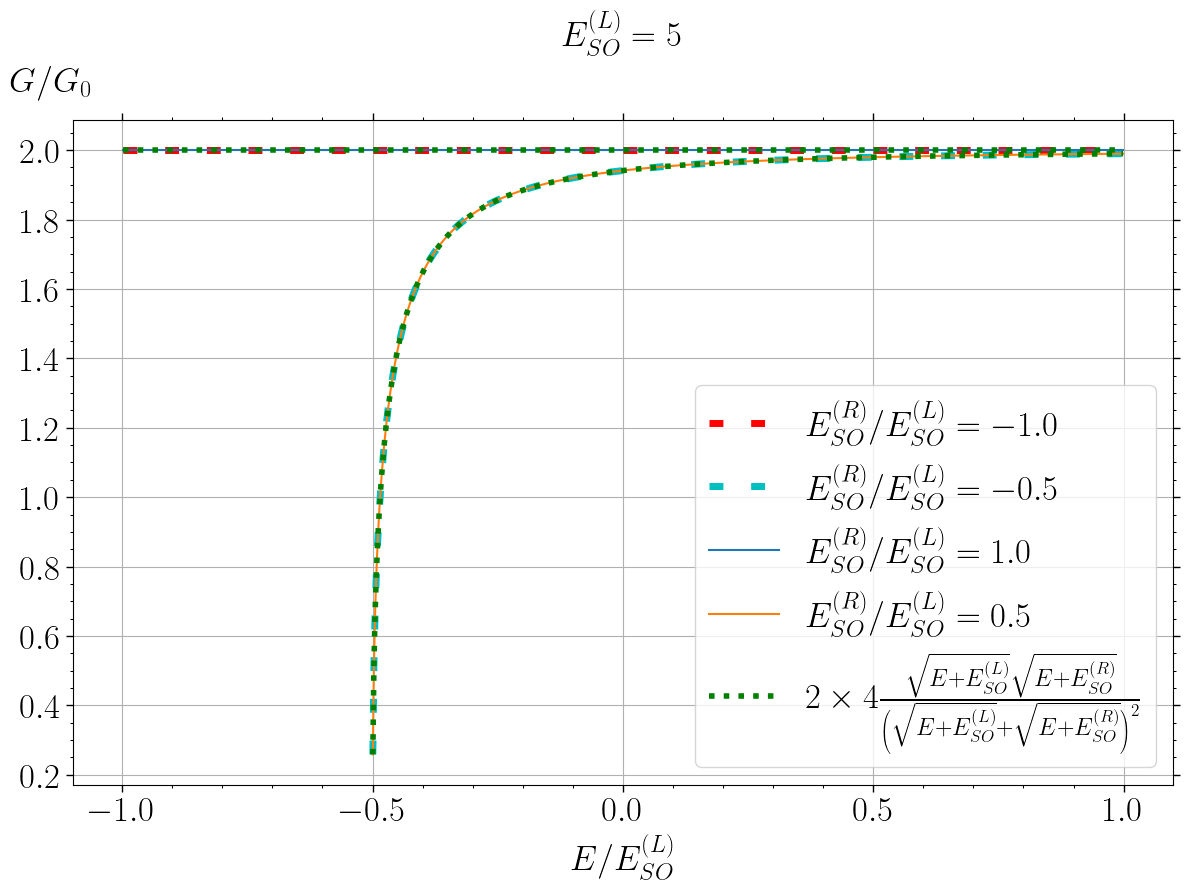

In [7]:
%matplotlib inline

# reload(plt)
# %matplotlib notebook
# %matplotlib notebook
# import matplotlib.pyplot as plt 


# plt.rcParams['text.usetex'] = False
plt.rcParams['text.usetex'] = True

# fig, axs = plt.subplots(1, figsize=(14, 6), dpi=100, tight_layout=True, facecolor='white')
fig, axs = plt.subplots(1, figsize=(12, 9), dpi=100, tight_layout=True, facecolor='white')

k_list = list(trasmission_coeff_total.keys())

c = ["r", "c"]
i = 0
for k in k_list[2:]:
    labll = r"$E_{SO}^{(R)} / E_{SO}^{(L)} = "f"{k}$"
    
    print(k)
    axs.plot(enn/alp_l, trasmission_coeff_total[k][0],
                   label=labll, linestyle=(0, (2, 4)), color=c[i], linewidth=5)
    i+=1

    
ll = [None, r"$ \small 2 \times 4\frac{\sqrt{E + E_{SO}^{(L)}}\sqrt{E + E_{SO}^{(R)}}}{\Bigg(\sqrt{E + E_{SO}^{(L)}} + \sqrt{E + E_{SO}^{(R)}}\Bigg)^2}$"]
i = 0
for k in k_list[:2]:
    labll = r"$E_{SO}^{(R)} / E_{SO}^{(L)} = "f"{k}$"
    print(k)
    axs.plot(enn/alp_l, trasmission_coeff_total[k][0],
                   label=labll)
    axs.plot(enn/alp_l, [potential_step(i, k) for i in enn/alp_l],
                   label=ll[i], linestyle="dotted", color='green', linewidth=4)
    i+=1
    


axs.grid()
axs.legend(fontsize = legend_font_size)
axs.set_xlabel(x_label, fontdict=font)
axs.set_ylabel(y_label, rotation=0, fontdict=font)
axs.yaxis.set_label_coords(*y_label_pos[0])

x_magior = np.array([0.5])
x_minor = np.array([0.1])

y_magior = np.array([0.2])
y_minor = np.array([0.05])
adjuct_Tick(np.array([axs]), x_magior=x_magior, 
                    x_minor=x_minor, 
                    y_magior=y_magior, 
                    y_minor=y_minor, 
                    size =font["size"])

# axs.set_ylim(1, 2.1)

# plt.title(r"$k_{SO} \, d = "+f"{k_list[0][0]}$", 
plt.title(r"$E_{SO}^{(L)} = "+f"{alp_l}$", 
              fontsize = 25, x=0.5, y=1.1)



SAVE = True
# SAVE = False

save_path = BASE_PATH+"pure_rashba/"+f"pure_rashba.pdf"
print(save_path)

if SAVE:
    plt.savefig(save_path, 
            transparent = False, 
            bbox_inches='tight')

plt.show()